# Distribution of the safeguarded compression error

In this example, we analyse the distribution of the compression error produced by a simple absolute-error safeguard. We compare several cases of different prediction distributions (distribution of the decompressed data produced by a wrapped compressor) that the safeguards take as input.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-pr" / "data.nc")

In [4]:
# Extract the precipitation variable
with xr.set_options(keep_attrs=True):
    ERA5_PR = ERA5["tp"] * 1000
ERA5_PR.attrs.update(units="mm", GRIB_units="mm")

In [5]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [6]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [7]:
def moran_i_global(x: xr.DataArray) -> float:
    x_mean = x.mean().item()

    x_mid = x - x_mean

    denom = np.square(x_mid).sum()

    if denom == 0.0:
        return x.dtype.type(1)

    neighbours = []

    # Only include the direct ±1 neighbours
    for dim in x.dims:
        neighbours.append(x.shift({dim: -1}))
        neighbours.append(x.shift({dim: +1}))

    neighbour_sum = sum(neighbours) - (x_mean * len(neighbours))

    return (neighbour_sum * x_mid).sum() / (denom * len(neighbours))

In [8]:
def plot_mean_precipitation(
    my_ERA5_PR: xr.DataArray,
    chart,
    title,
    span,
    eb_abs,
    error=False,
    corr=None,
):
    import copy

    if error:
        err_inf_PR = np.amax(np.abs(my_ERA5_PR - ERA5_PR))
        err_2_PR = np.sqrt(np.mean(np.square(my_ERA5_PR - ERA5_PR)))
        bias_PR = np.mean(my_ERA5_PR - ERA5_PR)
        moran_i_PR = moran_i_global(my_ERA5_PR - ERA5_PR)
        err_v = np.mean(~(np.abs(my_ERA5_PR - ERA5_PR) <= eb_abs))

        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_PR - ERA5_PR).compute()

        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        da = my_ERA5_PR

    with xr.set_options(keep_attrs=True):
        da = da.mean(dim="valid_time").compute()

    da.attrs.update(long_name=f"Mean {da.long_name.lower()}")

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    if error:
        style._levels = earthkit.plots.styles.levels.Levels(
            np.linspace(-span, span, 22)
        )
        style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
        style._colors = "coolwarm"
    else:
        style._levels = earthkit.plots.styles.levels.Levels(np.linspace(0, span, 22))
        style._legend_kwargs["ticks"] = np.linspace(0, span, 5)
        style._colors = "BuPu"

    extend_left = np.nanmin(da) < (-span if error else 0)
    extend_right = np.nanmax(da) > span

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    irwin_hall_error_sum_spread = np.sqrt(ERA5_PR.valid_time.size / 12)
    expected_mean_error_spread = (
        span * irwin_hall_error_sum_spread / ERA5_PR.valid_time.size
    )
    expected_mean_error_spread_2 = expected_mean_error_spread * 2  # ~95%

    with xr.set_options(keep_attrs=True):
        da_hatch = np.abs(da) <= expected_mean_error_spread_2

    if error:
        plt.rcParams["hatch.color"] = (0.0, 0.0, 0.0, 0.5)
        plt.rcParams["hatch.linewidth"] = 0.5

        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-12)
        chart.legend()
        chart.contourf(
            x=np.broadcast_to(da_hatch.longitude.values.reshape(1, -1), da_hatch.shape),
            y=np.broadcast_to(da_hatch.latitude.values.reshape(-1, 1), da_hatch.shape),
            z=da_hatch.values,
            colors="none",
            levels=[-0.5, 0.5, 1.5],
            hatches=[r"xx", None],
            zorder=-11,
        )
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)
        chart.legend()

    chart.ax.set_rasterization_zorder(-10)

    if error:
        corr = None if corr is None else np.mean(corr != 0)

        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{PR}}}})$={err_inf_PR:.02}  "
            + rf"$L_{{{{2}}}}(\hat{{{{PR}}}})$={err_2_PR:.02}  "
            + f"V={0 if err_v == 0 else np.format_float_positional(100 * err_v, precision=1, min_digits=1) + '%'}"
            + (
                ""
                if corr is None
                else (
                    f"  C={0 if corr == 0 else np.format_float_positional(100 * corr, precision=1, min_digits=1) + '%'}"
                )
            )
            + "\n"
            + rf"$bias(\hat{{{{PR}}}})$={bias_PR:.02}  "
            + rf"$I(\hat{{{{PR}}}}-PR)$={moran_i_PR:.02}"
        )
    else:
        chart.title(f"{title}\n\n")

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        if m != "legend":
            getattr(chart, m)()

    counts, bins = np.histogram(
        da.values.flatten(), range=(-span if error else 0, span), bins=21
    )
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    cax = cb.ax.inset_axes([0.0, 1.25, 1.0, 1.0])
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
        edgecolor=None if error else "grey",
    )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    if error:
        cax.axvline(-expected_mean_error_spread_2, c="red", lw=2)
        cax.axvline(expected_mean_error_spread_2, c="red", lw=2)
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(-span if error else 0, span)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

## Compressing accumulated precipitation with safeguards

We compress the accumulated precipitation, in mm / 1h, with an absolute error bound of 0.1 mm / h.

In [9]:
eb_abs = 0.1

In [10]:
# constant zero prediction, biased
ERA5_PR_zero = np.zeros(ERA5_PR.shape, dtype=ERA5_PR.dtype)

# constant mean prediction, unbiased
ERA5_PR_mean = np.full(ERA5_PR.shape, np.mean(ERA5_PR.values), dtype=ERA5_PR.dtype)

# biased prediction within the error bound
ERA5_PR_bias = ERA5_PR.values + eb_abs / 2

# uniform noise prediction around the expected value exceeding the error bound
ERA5_PR_uniform = ERA5_PR.values + np.random.Generator(
    np.random.PCG64(seed=42)
).uniform(-eb_abs * 3, eb_abs * 3, size=ERA5_PR.shape).astype(ERA5_PR.dtype)

In [11]:
from compression_safeguards import Safeguards

In [12]:
ERA5_PR_sg = dict()
ERA5_PR_sg_corr = dict()

for key, ERA5_PR_prediction in dict(
    zero=ERA5_PR_zero,
    mean=ERA5_PR_mean,
    bias=ERA5_PR_bias,
    uniform=ERA5_PR_uniform,
).items():
    sg = Safeguards(
        safeguards=[
            dict(kind="eb", type="abs", eb=eb_abs),
        ],
    )

    ERA5_PR_sg_corr[key] = sg.compute_correction(ERA5_PR.values, ERA5_PR_prediction)
    ERA5_PR_sg[key] = ERA5_PR.copy(
        data=sg.apply_correction(ERA5_PR_prediction, ERA5_PR_sg_corr[key])
    )

## Visual comparison of the error distributions

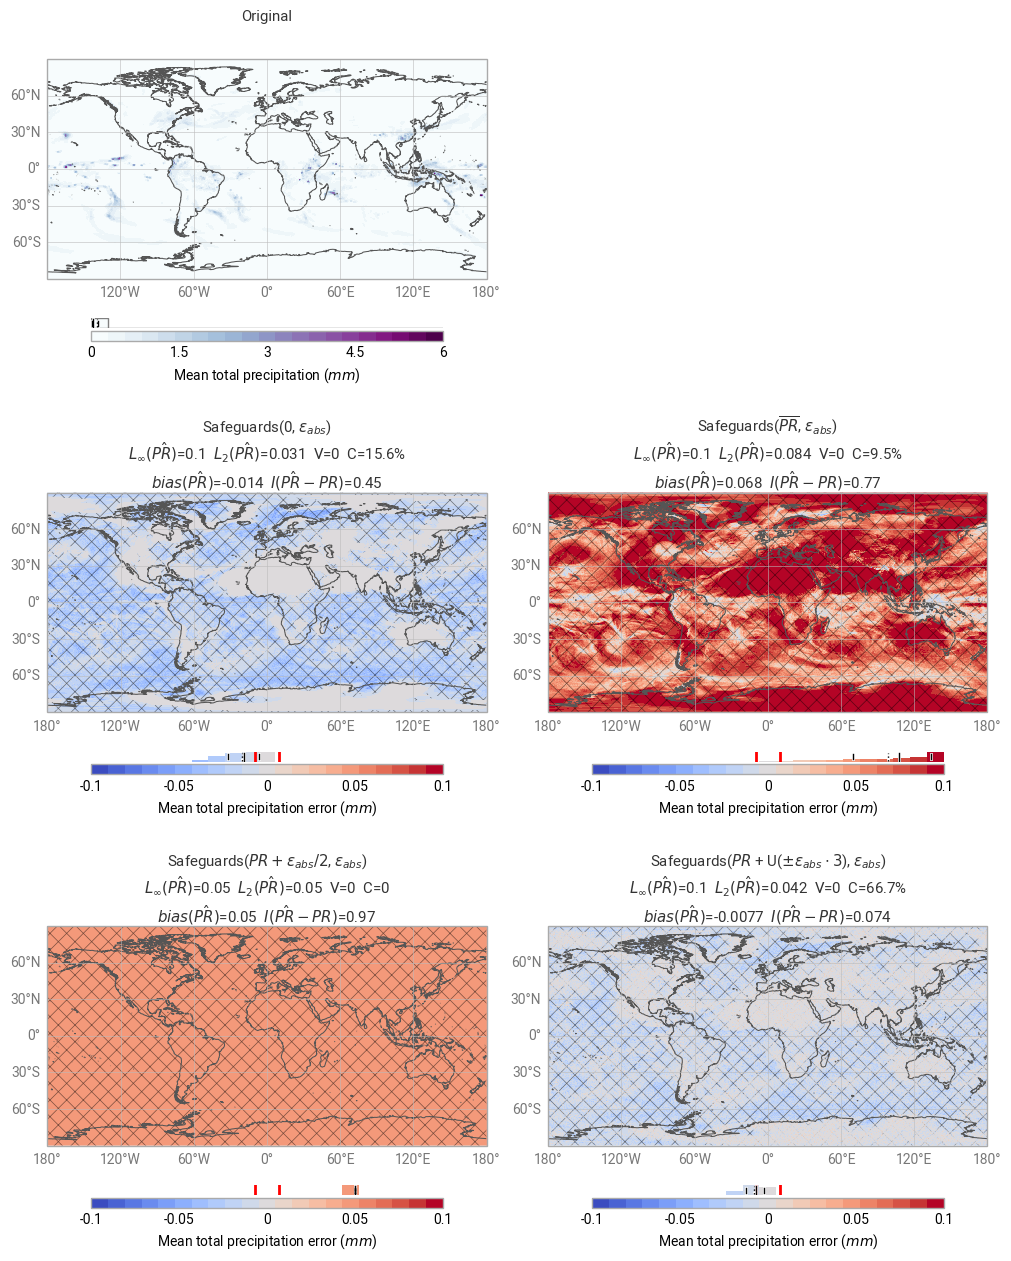

In [13]:
fig = earthkit.plots.Figure(
    size=(10, 13),
    rows=3,
    columns=2,
)

plot_mean_precipitation(ERA5_PR, fig.add_map(0, 0), "Original", span=6, eb_abs=eb_abs)

plot_mean_precipitation(
    ERA5_PR_sg["zero"],
    fig.add_map(1, 0),
    r"Safeguards(0, $\epsilon_{{abs}}$)",
    span=eb_abs,
    eb_abs=eb_abs,
    error=True,
    corr=ERA5_PR_sg_corr["zero"],
)
plot_mean_precipitation(
    ERA5_PR_sg["mean"],
    fig.add_map(1, 1),
    r"Safeguards($\overline{{PR}}$, $\epsilon_{{abs}}$)",
    span=eb_abs,
    eb_abs=eb_abs,
    error=True,
    corr=ERA5_PR_sg_corr["mean"],
)

plot_mean_precipitation(
    ERA5_PR_sg["bias"],
    fig.add_map(2, 0),
    r"Safeguards($PR + \epsilon_{{abs}} / 2$, $\epsilon_{{abs}}$)",
    span=eb_abs,
    eb_abs=eb_abs,
    error=True,
    corr=ERA5_PR_sg_corr["bias"],
)
plot_mean_precipitation(
    ERA5_PR_sg["uniform"],
    fig.add_map(2, 1),
    r"Safeguards($PR$ + U($\pm \epsilon_{{abs}} \cdot 3$), $\epsilon_{{abs}}$)",
    span=eb_abs,
    eb_abs=eb_abs,
    error=True,
    corr=ERA5_PR_sg_corr["uniform"],
)

fig.save("error-distribution.pdf")

We can see that the safeguards do *not* guard against bias in the compression error, e.g. a biased prediction within the error bounds is passed through as-is. Furthermore, using simple predictors such as constant zero or constant mean likely produces biased errors. Using an unbiased predictor reduces but does not eliminate the bias in the error distribution.